In [1]:
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import random
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from textwrap import wrap
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [2]:
annotations = pd.read_csv('/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv', delimiter='|')
images_dataset = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'

annotations['comment'] = annotations[' comment']
annotations['comment_number'] = annotations[' comment_number']
annotations.drop(columns = [' comment', ' comment_number'], inplace = True)

annotations.dropna(how = 'any', inplace = True)
annotations.reset_index(drop = True)

annotations.head(5)

,image_name,comment,comment_number
0,1000092795.jpg,Two young guys with shaggy hair look at their...,0
1,1000092795.jpg,"Two young , White males are outside near many...",1
2,1000092795.jpg,Two men in green shirts are standing in a yard .,2
3,1000092795.jpg,A man in a blue shirt standing in a garden .,3
4,1000092795.jpg,Two friends enjoy time spent together .,4


In [3]:
print(len(annotations))
print(len(os.listdir(images_dataset)))

158914
31785


As we see from above, we see that each image from the dataset (31k images) has about 5 captions (some has less) in the annotations dataset, making a total of 158,915 observations.

Let's pair each image to its caption

In [4]:
images_path = []
for i in range(len(annotations)):
    full_path = images_dataset + annotations['image_name'].values[i]
    images_path.append(full_path)

## Utility Functions & Img Parameters

In [5]:
img_height = 256
img_width = 256
n_channels = 3
max_words = 80000

# TF DATA parameters
BATCH_SIZE = 64
BUFFER_SIZE = 1000

embedding_dim = 256
units = 512

In [6]:
def display_images(count, captions = False, seed = 42):
    """
    Utility function to quickly display some number of images from the dataset
    
    Args:
    
        count: number of images to display, limit to 12
        captions: if the captions of each image should be set as title
        seed: default = 42, to load a different set of images
    """
    plt.figure(figsize=(20, 20))
    
    # set a maximum count of 12
    if count >= 12:
        count = 12
    
    # set the seed and create random numbers
    random.seed(seed)
    rnd_numbers = [random.randint(1, 10000) for _ in range(count)]
        
    for index, image in enumerate(images_path):
        plt.subplot(3, 4, index + 1)
        img = load_img(images_path[rnd_numbers[index]], target_size = (img_height, img_width))
        plt.imshow(img)
        plt.axis('off')
        
        if captions:
            title = tokenizer.sequences_to_texts([target[rnd_numbers[index]]])
            title = ('\n'.join(wrap(title[0], 20)))
            plt.title(title)
        
        if index == count - 1:
            break
    

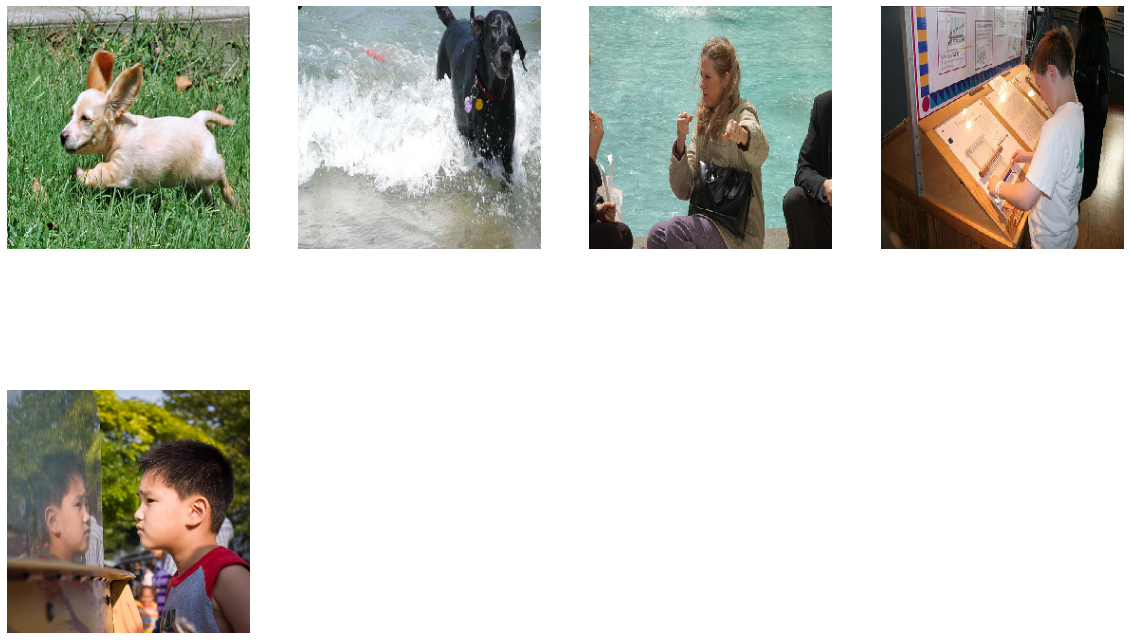

In [7]:
display_images(5)

## Preprocessing the text data

Let's add start and end tokens to the captions in the dataset

In [8]:
annotations.head()

,image_name,comment,comment_number
0,1000092795.jpg,Two young guys with shaggy hair look at their...,0
1,1000092795.jpg,"Two young , White males are outside near many...",1
2,1000092795.jpg,Two men in green shirts are standing in a yard .,2
3,1000092795.jpg,A man in a blue shirt standing in a garden .,3
4,1000092795.jpg,Two friends enjoy time spent together .,4


In [9]:
def add_start_end_tokens(text):
    return '<start> ' + str(text) + ' <end>'

annotations['comment'] = annotations['comment'].apply(add_start_end_tokens)

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

captions = annotations['comment'].values.tolist()

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(captions)

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

target = tokenizer.texts_to_sequences(captions)
target = pad_sequences(target, maxlen = 30,padding='post', truncating='post')

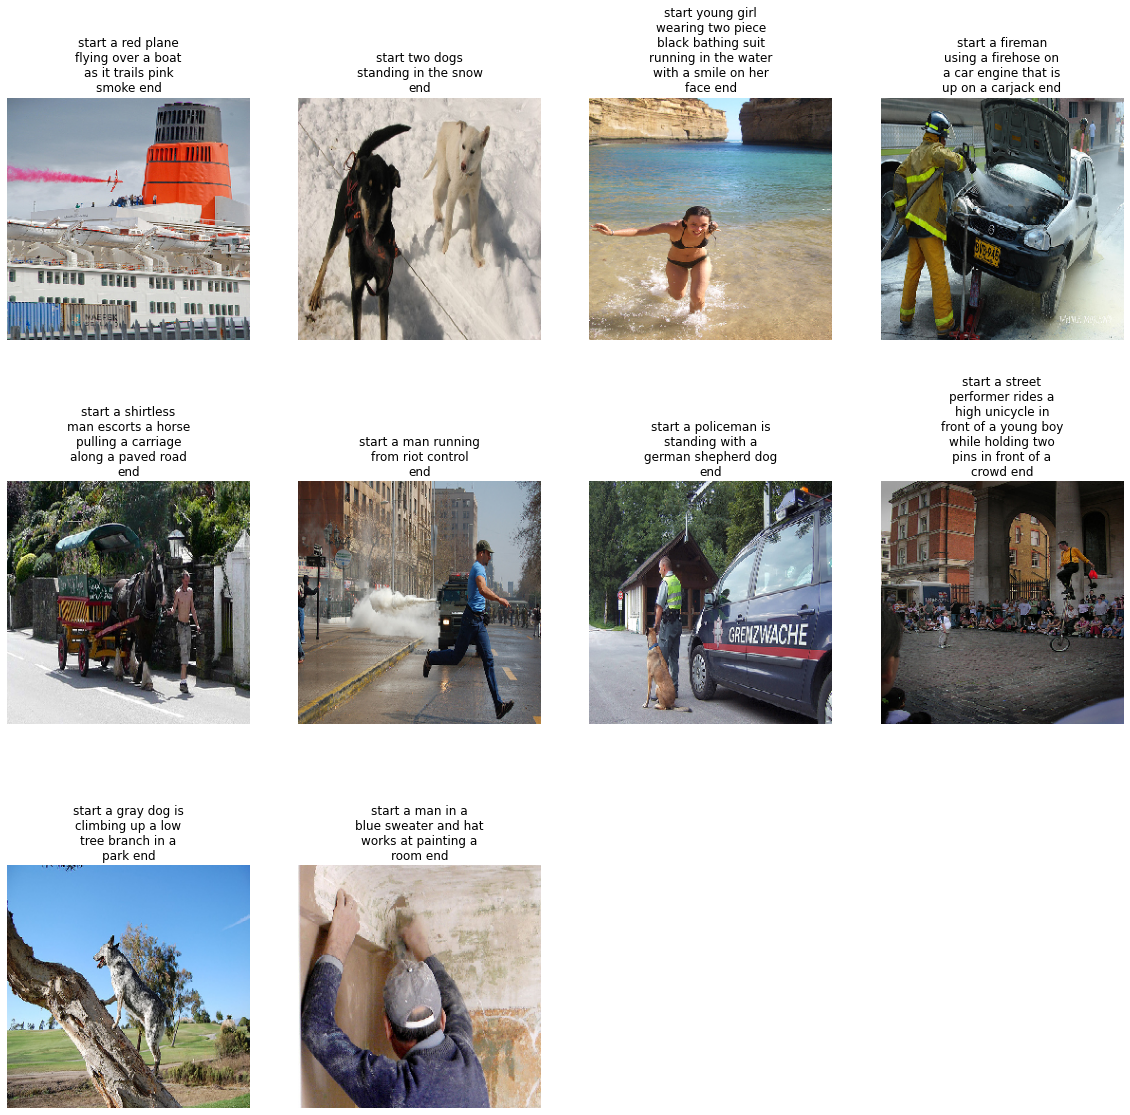

In [12]:
display_images(10, captions = True, seed = 12)

In [13]:
len(images_path), len(target)

(158914, 158914)

## Split into Train & Validation

Note that due to each image have 5 captions, we cannot splitting the data randomly. Here, to avoid knowledge leakage from train-set to valid-set, we must use GroupKFold to carefully make each image stays in the same set.

In [14]:
from sklearn.model_selection import GroupKFold

groups_kfold = GroupKFold(n_splits=3).split(X=images_path, groups=images_path)

for index, (train_index, val_index) in enumerate(groups_kfold):
    train_dataset = np.array(images_path)[train_index]
    val_dataset = np.array(images_path)[val_index]
    
    train_captions = target[train_index]
    val_captions = target[val_index]

In [15]:
len(train_dataset), len(train_captions)

(105944, 105944)

In [16]:
len(val_dataset), len(val_captions)

(52970, 52970)

In [17]:
train_dataset[0], train_captions[0]

('/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/10002456.jpg',
 array([   3,  120,   30,    4,  328,  273,   14, 1312,    1,  815, 3852,
        2639,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], dtype=int32))

## Using TF.Data

Let's use TensorFlow's TF.Data API to wrap the dataset

In [18]:
# create the datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_dataset, train_captions))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_dataset, val_captions))

2023-02-02 18:44:33.069045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 18:44:33.151018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 18:44:33.151940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 18:44:33.155224: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Now that we've wrapped the entire dataset in TF.Data.Dataset objects, we need to remember that the train_dataset and val_dataset hold two entities - the first which basically stores the paths to the images in each dataset, and the other which contains the captions to each image in numpy arrays. We need to load and convert the images in the former to numpy arrays.

In [19]:
def decode_image(filepath, caption):
    # read the image
    img = tf.io.read_file(filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(img_height, img_width)(img)
    img = img/255. 
    
    return img, caption

In [20]:
# map the decode_image function to the dataset
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(decode_image, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.map(lambda item1, item2: tf.numpy_function(decode_image, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [21]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE, drop_remainder=False).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Now we have the entities in the train and valid datasets to be image tensors and the vectorized text inputs ready for modelling.

## ML Model

### Encoder

The encoder is simply a model which receives the features extracted from the dataset and then feeds it into a Dense layer and returns the output which would be fed to a decoder

In [22]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.pretrained = efficientnet.EfficientNetB0(include_top=False, weights='imagenet', 
                                                      #input_shape=(img_height, img_width, n_channels))
        #self.pretrained = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', 
                                                input_shape=(img_height, img_width, n_channels))
        self.cnn = keras.Model(inputs = self.pretrained.input, outputs = self.pretrained.layers[-1].output)
        self.cnn.trainable = False
        self.fc = layers.Dense(embedding_dim)
        
    def __call__(self, x):
        x = self.cnn(x) # returns shape (batch_size, 6, 6, 2048)
        x = tf.reshape(x, (x.shape[0], -1, x.shape[3])) # reshape to 3D
        x = self.fc(x)
        x = tf.nn.relu(x)
        
        return x #shape == (batch_size, attention_features_shape, embedding_dim)

In [23]:
for batch, (img_tensor, captions) in enumerate(train_dataset):
    print(img_tensor.shape)
    print(captions.shape)
    
    if batch == 0: # to run only once
        break

2023-02-02 18:44:35.639486: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(64, 256, 256, 3)
(64, 30)


In [24]:
# sanity check for one image
img = img_tensor[0]
img = img.reshape((1, img_height, img_width, n_channels))
encoder = Encoder(embedding_dim)
output = encoder(img)

output.shape

16719872/16705208 [==============================] - 1s 0us/step


2023-02-02 18:44:48.453907: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


TensorShape([1, 64, 256])

### Decoder

Tutorial on Bahdanau Attention - [Machine Learning Mastery blog](https://machinelearningmastery.com/the-bahdanau-attention-mechanism/)

In [25]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [26]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(self.units, return_sequences=True, return_state=True, 
                                       recurrent_initializer= 'glorot_uniform')
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.units)
        
        # x=sequence of words
        # features=image's extracted features 
        # hidden=GRU's hidden unit
        
    def call(self, x, features, hidden):
        # compute the attention score
        context_vector, attention_weights = self.attention(features, hidden)
        
        # compute embedding for the text tokens and concat with the context vector
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        output, state = self.gru(x) # a recurrent neural network
        
        x = self.fc1(output)
        
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        
        return x, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [27]:
# end to end sanity check

for i, (img_tensor, captions) in tqdm(enumerate(train_dataset)):
    print(img_tensor.shape)
    print(captions.shape)
    if i == 0: # to run only once
        break

0it [00:04, ?it/s]

(64, 256, 256, 3)
(64, 30)


In [28]:
encoder = Encoder(embedding_dim)
decoder = Decoder(embedding_dim, units, max_words)

In [29]:
# the encoder

outputs = encoder(img_tensor)
outputs.shape

TensorShape([64, 64, 256])

In [30]:
# the decoder

hidden = decoder.reset_state(batch_size=1)
pred, _, _ = decoder(captions[:, 0:1], outputs, hidden)
pred.shape

TensorShape([64, 80000])

### Training

In [31]:
# initialize the encoder and decoder

encoder = Encoder(embedding_dim)
decoder = Decoder(embedding_dim, units, max_words)

In [32]:
# optimizer and loss
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
        
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
        
    loss = tf.reduce_mean(loss_)
        
    return loss

In [33]:
# train function
@tf.function
def train_step(image_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['start']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(image_tensor)
        
        for i in range(target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1) # update the dec_input
             
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(target = loss, sources = trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss / target.shape[1]

We'll define the function for the validation dataset. However, due to RAM constraints, we won't be running it in this notebook.

In [34]:
# validation step
@tf.function
def val_step(image_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['start']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(image_tensor)
        
        for i in range(target.shape[1]):
            predictions, _, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1) # update the dec_input
    
    # since this is for validation, we won't be using the optimizer to update weights
    loss = loss / target.shape[1]
    return loss

def calc_val_loss():
    """Utility defined so that loss is reported per epoch"""
    total_loss = 0
    
    for batch, (image_tensor, target) in enumerate(valid_dataset):
        total_loss += val_step(image_tensor, target)
    
    n_batches = len(valid_dataset)//BATCH_SIZE
    return total_loss / n_batches

In [35]:
start_epoch = 0
epochs = 20
num_steps = len(train_dataset)//BATCH_SIZE

for epoch in range(start_epoch, epochs):
    start = time.time()
    
    for batch, (image_tensor, target) in enumerate(train_dataset):
        loss = train_step(image_tensor, target)
        
        if batch % 50 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {loss:.4f}')
            
    #avg_valid_loss = calc_val_loss()
    #print("")
    #print(f"Validation Loss for Epoch {epoch + 1} : {avg_valid_loss}")
    print(f'Time taken for that epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 5.3374
Epoch 1 Batch 50 Loss 2.8860
Epoch 1 Batch 100 Loss 2.7941
Epoch 1 Batch 150 Loss 2.5435
Epoch 1 Batch 200 Loss 2.6277
Epoch 1 Batch 250 Loss 2.5628
Epoch 1 Batch 300 Loss 2.5588
Epoch 1 Batch 350 Loss 2.4470
Epoch 1 Batch 400 Loss 2.6047
Epoch 1 Batch 450 Loss 2.5098
Epoch 1 Batch 500 Loss 2.6429
Epoch 1 Batch 550 Loss 2.5968
Epoch 1 Batch 600 Loss 2.4183
Epoch 1 Batch 650 Loss 2.3218
Epoch 1 Batch 700 Loss 2.5420
Epoch 1 Batch 750 Loss 2.7026
Epoch 1 Batch 800 Loss 2.6229
Epoch 1 Batch 850 Loss 2.5295
Epoch 1 Batch 900 Loss 2.4090
Epoch 1 Batch 950 Loss 2.8738
Epoch 1 Batch 1000 Loss 2.6416
Epoch 1 Batch 1050 Loss 2.6456
Epoch 1 Batch 1100 Loss 2.5697
Epoch 1 Batch 1150 Loss 2.5810
Epoch 1 Batch 1200 Loss 2.5473
Epoch 1 Batch 1250 Loss 2.7520
Epoch 1 Batch 1300 Loss 2.6676
Epoch 1 Batch 1350 Loss 2.8247
Epoch 1 Batch 1400 Loss 2.8374
Epoch 1 Batch 1450 Loss 2.7911
Epoch 1 Batch 1500 Loss 2.8851
Epoch 1 Batch 1550 Loss 3.0249
Epoch 1 Batch 1600 Loss 2.6976


KeyboardInterrupt: 

## Evaluation

In [36]:
max_length = 20

In [37]:
def _evaluate(image_tensor):
    """Lower-level nonpublic function to predict the caption for a given image input"""
    hidden = decoder.reset_state(batch_size=1) # predicting for only 1 image
    
    # reshape image tensor to expected shape by the encoder and pass to the encoder
    image_tensor = image_tensor.reshape((1, img_height, img_width, n_channels))
    features = encoder(image_tensor)
    
    dec_input = tf.expand_dims([tokenizer.word_index['start']], 0)
    results = []
    
    for i in range(max_length):
        predictions, _, _ = decoder(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(tokenizer.index_word[predicted_id])
        
        results.append(predicted_word)
        
        if predicted_word == 'end':
            return results
        
        # update the decoder & move to the next token
        dec_input = tf.expand_dims([predicted_id], 0)
        
    return results

In [38]:
def caption(image_path):
    """Function to preprocess an image for captioning and then runs the trained model for inference
    Relies on lower level _evaluate function for inference
    
    """
    
    img = load_img(image_path, target_size=(img_height, img_width))
    img = np.array(img)
    result = _evaluate(img)
    result = ' '.join(result)
    
    # plot the image
    plt.figure(figsize=(8, 8))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    title = ('\n'.join(wrap(result, 20)))
    plt.title(title)

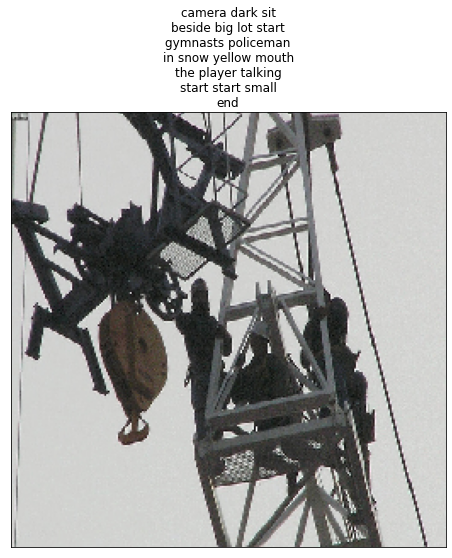

In [39]:
image_path = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/10002456.jpg'
caption(image_path)

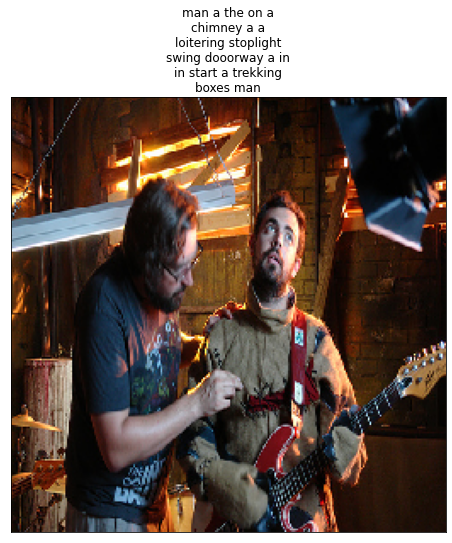

In [40]:
image_path = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000523639.jpg'
caption(image_path)

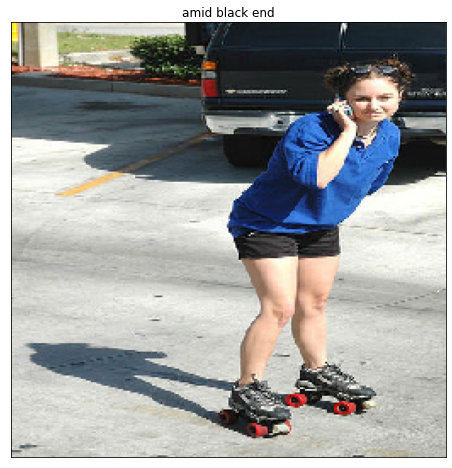

In [41]:
image_path = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/10010052.jpg'
caption(image_path)

## Resources 

Similar work to that in this notebook is done in the following

1. [Important Kaggle Notebook](https://www.kaggle.com/code/ratthachat/flickr-image-captioning-tpu-tf2-glove)
2. [TensorFlow Image Captioning](https://www.tensorflow.org/tutorials/text/image_captioning), [Notebook](https://www.kaggle.com/code/ratthachat/image-captioning-by-effnet-attention-in-tf2-1/notebook)
3. [Machine Learning Mystery Blog](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/) 
4. [Flickr8k captioning with CNN & LSTMs](https://www.kaggle.com/code/quadeer15sh/flickr8k-image-captioning-using-cnns-lstms)
5. [Captioning with Transformers Pytorch](https://www.kaggle.com/code/tathagatbanerjee/transformer-based-image-captioning)
6. [Attempt using VGG16](https://www.kaggle.com/code/anunay999/image-captioning-using-vgg16)